In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch 
from nltk.probability import FreqDist
from collections import Counter
from functools import reduce
nltk.download('stopwords')
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cameliaguerraoui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
_TEXT = "text"
_LABEL = "name"
_PATH = "8-9_Data"
_CLUSTER = "cluster"

# Data Exploration

In [19]:
import requests
from bs4 import BeautifulSoup

url_list = [
    ['Akumaki', 'https://en.wikipedia.org/wiki/Akumaki'],
    ['Amanatto', 'https://en.wikipedia.org/wiki/Amanatt%C5%8D'],
    ['Arare', 'https://en.wikipedia.org/wiki/Arare_(food)'],
    ['Beika', 'https://en.wikipedia.org/wiki/Beika'],
    ['Botamochi', 'https://en.wikipedia.org/wiki/Botamochi'],
    ['Daifuku', 'https://en.wikipedia.org/wiki/Daifuku'],
    ['Dango', 'https://en.wikipedia.org/wiki/Dango'],
    ['Dorayaki', 'https://en.wikipedia.org/wiki/Dorayaki'],
    ['Gionbo', 'https://en.wikipedia.org/wiki/Gionb%C5%8D'],
    ['Gyuhi', 'https://en.wikipedia.org/wiki/Gy%C5%ABhi'],
    ['Hanabiramochi', 'https://en.wikipedia.org/wiki/Hanabiramochi'],
    ['Higashi', 'https://en.wikipedia.org/wiki/Higashi_(food)'],
    ['Hishi', 'https://en.wikipedia.org/wiki/Hishi_mochi'],
    ['Imagawayaki', 'https://en.wikipedia.org/wiki/Imagawayaki'],
    ['Karinto', 'https://en.wikipedia.org/wiki/Karint%C5%8D'],
    ['Konpeito', 'https://en.wikipedia.org/wiki/Konpeit%C5%8D'],
    ['Kuzumochi', 'https://en.wikipedia.org/wiki/Kuzumochi'],
    ['Manju', 'https://en.wikipedia.org/wiki/Manj%C5%AB'],
    ['Mizuame', 'https://en.wikipedia.org/wiki/Mizuame'],
    ['Monaka', 'https://en.wikipedia.org/wiki/Monaka'],
    ['Namagashi', 'https://en.wikipedia.org/wiki/Namagashi'],
    ['Sakuramochi', 'https://en.wikipedia.org/wiki/Sakuramochi'],
    ['Senbei', 'https://en.wikipedia.org/wiki/Senbei'],
    ['Taiyaki', 'https://en.wikipedia.org/wiki/Taiyaki'],
    ['Tokoroten', 'https://en.wikipedia.org/wiki/Tokoroten'],
    ['Uiro', 'https://en.wikipedia.org/wiki/Uir%C5%8D'],
    ['Warabimochi', 'https://en.wikipedia.org/wiki/Warabimochi'],
    ['Wasanbon', 'https://en.wikipedia.org/wiki/Wasanbon'],
    ['Yatsuhashi', 'https://en.wikipedia.org/wiki/Yatsuhashi'],
    ['Yokan', 'https://en.wikipedia.org/wiki/Y%C5%8Dkan'],
    ['Yubeshi', 'https://en.wikipedia.org/wiki/Yubeshi']
]

url = pd.DataFrame(url_list, columns=[_LABEL, _TEXT])

url[_TEXT] = [BeautifulSoup(requests.get(url).content).get_text() for url in url[_TEXT]]
url.to_csv(f"{_PATH}/wagashi.csv")

In [66]:
df = url.copy()

In [77]:
df = pd.read_csv(f"{_PATH}/wagashi_minimal.csv")

## Tokenize
regexp = RegexpTokenizer("\w+")
df[_TEXT] = df[_TEXT].apply(regexp.tokenize)

## Lower case
df[_TEXT] = df[_TEXT].apply(lambda x:[item.lower() for item in x])

## Removing Stopwords
df[_TEXT] = df[_TEXT].apply(lambda x: [item for item in x if item not in en_stopwords])

## Stemming using Porter Stemmer
stemmer = PorterStemmer()
df[_TEXT] = df[_TEXT].apply(lambda x: [stemmer.stem(item) for item in x])

## Dropping words that appear in all documents
common_words = list(reduce(set.intersection, [set(item) for item in df[_TEXT] ]))
df[_TEXT] = df[_TEXT].apply(lambda x:[item for item in x if item not in common_words])

## Dropping Short Words
df[_TEXT] = df[_TEXT].apply(lambda x: [item for item in x if len(item)>2])

## Using Bigrams
#df[_TEXT] = df[_TEXT].apply(lambda x: list(nltk.ngrams(x, 2))) 

## Not dropping infrequent words

## Saving output
df.to_csv(f"{_PATH}wagashi_preprocessed.csv")

## TF-IDF

In [78]:
## Make Tfidf Matrix
vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
tfidf_encodings = vectorizer.fit_transform(np.array(df[_TEXT].astype(str))) 
df_tfidf = tfidf_encodings.toarray()
vectors_for_training = np.array(df_tfidf.tolist()) 
print(vectors_for_training.shape)

(31, 6646)


## Clustering

https://en.wikipedia.org/wiki/List_of_Japanese_desserts_and_sweets

In [79]:
def _get_cluster_items(cluster_id: int, cluster_df: object, text_df: object = df) -> object:
    cluster_elemts = cluster_df[cluster_df.cluster == cluster_id][_LABEL]
    cluster_text = text_df.loc[text_df[_LABEL].isin(cluster_elemts)][_TEXT]
    print(cluster_elemts)
    return cluster_text

def _count_tokens(clusters_text: list) -> map:
    frequence = Counter()
    common_words = list(reduce(set.intersection, [set(item) for item in clusters_text]))
    for tokens_in_cluster in clusters_text:
        for token in tokens_in_cluster:
            if token in common_words:
                frequence[token] += 1
    mult_occurences = []
    for k in frequence:
        mult_occurences.append((k, frequence[k]))
    mult_occurences.sort(key=lambda t: t[1], reverse=True)
    return mult_occurences

In [89]:
_NB_CLUSTERS = 4

#cluster_model = AgglomerativeClustering(n_clusters=_NB_CLUSTERS, linkage='average').fit(vectors_for_training)
#cluster_model = KMeans(n_clusters=_NB_CLUSTERS).fit(vectors_for_training)
cluster_model = Birch(n_clusters=_NB_CLUSTERS).fit(vectors_for_training)

results = pd.DataFrame(
            np.hstack((cluster_model.labels_.reshape(-1,1), 
            (df[_LABEL].values.reshape(-1,1))))
        )
results.columns = [_CLUSTER, _LABEL]
results.sort_values(by=_CLUSTER)

for id in range(0, _NB_CLUSTERS):
    cluster_text = _get_cluster_items(id, results)
    print(_count_tokens(cluster_text))
    print()


0           Akumaki
6             Dango
9             Gyuhi
10    Hanabiramochi
12            Hishi
14          Karinto
16        Kuzumochi
18          Mizuame
21      Sakuramochi
24        Tokoroten
25             Uiro
26      Warabimochi
28       Yatsuhashi
30          Yubeshi
Name: name, dtype: object
[]

1      Amanatto
8        Gionbo
11      Higashi
15     Konpeito
20    Namagashi
27     Wasanbon
Name: name, dtype: object
[('use', 18), ('sweet', 7)]

4       Botamochi
5         Daifuku
7        Dorayaki
13    Imagawayaki
17          Manju
19         Monaka
23        Taiyaki
29          Yokan
Name: name, dtype: object
[('bean', 38), ('past', 30), ('made', 29), ('sweet', 22), ('media', 8)]

2      Arare
3      Beika
22    Senbei
Name: name, dtype: object
[('senbei', 55), ('rice', 17), ('arar', 15), ('type', 9), ('includ', 7), ('made', 6), ('media', 3)]



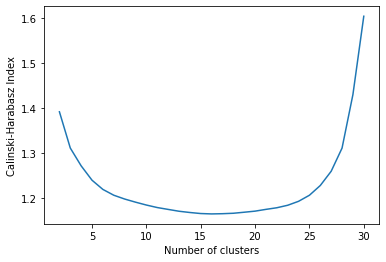

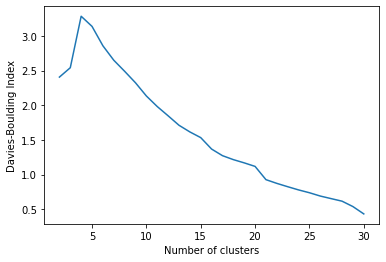

In [25]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

results_ch = {}
results_db = {}

for i in range(2,31):
    cluster_model = Birch(n_clusters=i).fit(vectors_for_training)
    ch_index = calinski_harabasz_score(vectors_for_training, cluster_model.labels_)
    db_index = davies_bouldin_score(vectors_for_training, cluster_model.labels_)
    results_ch.update({i: ch_index})
    results_db.update({i: db_index})

plt.plot(list(results_ch.keys()), list(results_ch.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

plt.plot(list(results_db.keys()), list(results_db.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

1. Tokenization

Tokenization is the process of parsing text data into smaller units (tokens) such as words and phrases. Commonly used tokenization methods include Bag-of-words model and N-gram model.

2. Stemming and lemmatization

Different tokens might carry out similar information (e.g. tokenization and tokenizing). And we can avoid calculating similar information repeatedly by reducing all tokens to its base form using various stemming and lemmatization dictionaries.

3. Removing stop words and punctuation

Some tokens are less important than others. For instance, common words such as "the" might not be very helpful for revealing the essential characteristics of a text. So usually it is a good idea to eliminate stop words and punctuation marks before doing further analysis.

4. Computing term frequencies or tf-idf

After pre-processing the text data, we can then proceed to generate features. For document clustering, one of the most common ways to generate features for a document is to calculate the term frequencies of all its tokens. Although not perfect, these frequencies can usually provide some clues about the topic of the document. And sometimes it is also useful to weight the term frequencies by the inverse document frequencies. See tf-idf for detailed discussions.

5. Clustering

We can then cluster different documents based on the features we have generated. See the algorithm section in cluster analysis for different types of clustering methods.

6. Evaluation and visualization

Finally, the clustering models can be assessed by various metrics. And it is sometimes helpful to visualize the results by plotting the clusters into low (two) dimensional space. See multidimensional scaling as a possible approach.